The purpose of this notebook is to simulate statistical power for the linear regression.

In [1]:
#Load packages
library(tidyverse)
library(reshape2)
library(pwr)
library(viridis)

show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: viridisLite



The first step is to load in the rfmix data and format it so that we know the ancestry fraction for each cell line

In [2]:
#Load in the rfmix data
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.file.list = list.files(path = ".", pattern = ".Q")
rfmix.file.list

#Compile it all into a single object
rfmix.data = NULL #create an empty object to hold the data
index = 0 #define the for loop index
for(file in rfmix.file.list){
    index = index + 1 #increase the index
    
    
    #Load in and format the data
    individual.chromosome = read.table(file, fill = TRUE) %>%
    rename("sample" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
    select(-sample)
    
    
    
    #Add the data to the main data frame
    if(index == 1) {
        rfmix.data = individual.chromosome
    } else {
        rfmix.data = rfmix.data + individual.chromosome
    }
    
    
    
    #Divide the data by the number of chromosomes to get the ancestry fraction across the genome
    if(index == length(rfmix.file.list)) {
        rfmix.data = rfmix.data/length(rfmix.file.list)
    }
    
    
    
    #Re-add the sample names
    if(index == length(rfmix.file.list)){
        sample.names = read.table(file, fill = TRUE) %>%
        rename("sample" = 1) %>%
        pull(sample) 
        
    rfmix.data = rfmix.data %>%
        mutate(sample = sample.names, .before = "AFR")
    }
    
}

head(rfmix.data)


[1] "chr1.rfmix.output.rfmix.Q"  "chr10.rfmix.output.rfmix.Q"
 [3] "chr11.rfmix.output.rfmix.Q" "chr12.rfmix.output.rfmix.Q"
 [5] "chr13.rfmix.output.rfmix.Q" "chr14.rfmix.output.rfmix.Q"
 [7] "chr15.rfmix.output.rfmix.Q" "chr16.rfmix.output.rfmix.Q"
 [9] "chr17.rfmix.output.rfmix.Q" "chr18.rfmix.output.rfmix.Q"
[11] "chr19.rfmix.output.rfmix.Q" "chr2.rfmix.output.rfmix.Q" 
[13] "chr20.rfmix.output.rfmix.Q" "chr21.rfmix.output.rfmix.Q"
[15] "chr22.rfmix.output.rfmix.Q" "chr3.rfmix.output.rfmix.Q" 
[17] "chr4.rfmix.output.rfmix.Q"  "chr5.rfmix.output.rfmix.Q" 
[19] "chr6.rfmix.output.rfmix.Q"  "chr7.rfmix.output.rfmix.Q" 
[21] "chr8.rfmix.output.rfmix.Q"  "chr9.rfmix.output.rfmix.Q"

,sample,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


Now we need to create the distributions

I think the best plan for this is to:

1) bin the cell lines by major ancestry group
2) perform linear regression (with subtype correction) for groups with different distribution differences

In [3]:
#Get lists of all of the cell lines for each ancestry group.
AFR.lines = rfmix.data %>% filter(AFR >= 0.5) %>% pull(sample)
AMR.lines = rfmix.data %>% filter(AMR >= 0.5) %>% pull(sample)
EAS.lines = rfmix.data %>% filter(EAS >= 0.5) %>% pull(sample)
EUR.lines = rfmix.data %>% filter(EUR >= 0.5) %>% pull(sample)
SAS.lines = rfmix.data %>% filter(SAS >= 0.5) %>% pull(sample)

#Calculate how many cell lines are in each ancestry group
length.AFR = AFR.lines %>% length()
length.AMR = AMR.lines %>% length()
length.EAS = EAS.lines %>% length()
length.EUR = EUR.lines %>% length()
length.SAS = SAS.lines %>% length()

#Calculate how many cell lines are not in each ancestry group
length.non.AFR = nrow(rfmix.data) - length.AFR
length.non.AMR = nrow(rfmix.data) - length.AMR
length.non.EAS = nrow(rfmix.data) - length.EAS
length.non.EUR = nrow(rfmix.data) - length.EUR
length.non.SAS = nrow(rfmix.data) - length.SAS

In [4]:
#Load in the chronos data to determine the median sd across all genes
setwd('/home/jupyter/Ancestry/gwas')
median.chronos.sd = read.table('CRISPR_gene_effect.csv', sep = ",") %>%
slice(-1) %>%
select(-1) %>%
apply(2, sd) %>%
median(na.rm = TRUE)

median.chronos.sd

[1] 0.09796036

Calculate all of the p-values for each ancestry group.

In [5]:
#Calculate for AFR

#Create a vector that has all of the median differences in it
median.differences = seq(from = 0, to = 1, by = 0.01)


#Grab the ancestry fraction for all of the AFR cell lines
afr.ancestry.fraction = rfmix.data %>%
filter(sample %in% AFR.lines) %>%
pull(AFR)


#Grab the ancestry fraction for all of the non-AFR cell lines
non.afr.ancestry.fraction = rfmix.data %>%
filter(!sample %in% AFR.lines) %>%
pull(AFR)

final.afr.pval.vector = NULL
for(i in 1:length(median.differences)){

#Calculate the distribution for each group of samples
dist.AFR = rerun(rnorm(length.AFR, mean = median.differences[i], sd = 1), .n = 100)
dist.non.AFR = rerun(rnorm(length.non.AFR, mean = 0, sd = 1), .n = 100)
    
        pval.vector = NULL
        #calculate the p-value for each comparison
        for(j in 1:length(dist.AFR)){
            
            #construct the data frame
            afr.labels = afr.ancestry.fraction #generate a vector of labels for the african cell lines
            non.afr.labels = non.afr.ancestry.fraction #generate a vector of labels for the non-african cell lines
            labels.vector = c(afr.labels, non.afr.labels) #combine the two into a single vector
            
            afr.values = dist.AFR[[j]] #Get a vector of the african values
            non.afr.values = dist.non.AFR[[j]] #Get a vector of the non-african values
            values.vector = c(afr.values, non.afr.values) #create a combined vector
            
            temp.pval = wilcox.test(x = afr.values, y = non.afr.values)  
            temp.pval = temp.pval$p.value
            pval.vector[j] = temp.pval
        }    
    
#Calculate the median pval
final.afr.pval.vector[i] = pval.vector %>% median()
}



In [6]:
#Calculate for AMR

#Create a vector that has all of the median differences in it
median.differences = seq(from = 0, to = 1, by = 0.01)


#Grab the ancestry fraction for all of the AMR cell lines
amr.ancestry.fraction = rfmix.data %>%
filter(sample %in% AMR.lines) %>%
pull(AMR)


#Grab the ancestry fraction for all of the non-AMR cell lines
non.amr.ancestry.fraction = rfmix.data %>%
filter(!sample %in% AMR.lines) %>%
pull(AMR)

final.amr.pval.vector = NULL
for(i in 1:length(median.differences)){

#Calculate the distribution for each group of samples
dist.AMR = rerun(rnorm(length.AMR, mean = median.differences[i], sd = 1), .n = 100)
dist.non.AMR = rerun(rnorm(length.non.AMR, mean = 0, sd = 1), .n = 100)
    
        pval.vector = NULL
        #calculate the p-value for each comparison
        for(j in 1:length(dist.AMR)){
            
            #construct the data frame
            amr.labels = amr.ancestry.fraction #generate a vector of labels for the american cell lines
            non.amr.labels = non.amr.ancestry.fraction #generate a vector of labels for the non-american cell lines
            labels.vector = c(amr.labels, non.amr.labels) #combine the two into a single vector
            
            amr.values = dist.AMR[[j]] #Get a vector of the american values
            non.amr.values = dist.non.AMR[[j]] #Get a vector of the non-american values
            values.vector = c(amr.values, non.amr.values) #create a combined vector
    
            temp.pval = wilcox.test(x = amr.values, y = non.amr.values)  
            temp.pval = temp.pval$p.value
            pval.vector[j] = temp.pval
        }    
    
#Calculate the median pval
final.amr.pval.vector[i] = pval.vector %>% median()
}



In [7]:
#Calculate for EAS

#Create a vector that has all of the median differences in it
median.differences = seq(from = 0, to = 1, by = 0.01)


#Grab the ancestry fraction for all of the EAS cell lines
eas.ancestry.fraction = rfmix.data %>%
filter(sample %in% EAS.lines) %>%
pull(EAS)


#Grab the ancestry fraction for all of the non-EAS cell lines
non.eas.ancestry.fraction = rfmix.data %>%
filter(!sample %in% EAS.lines) %>%
pull(EAS)

final.eas.pval.vector = NULL
for(i in 1:length(median.differences)){

#Calculate the distribution for each group of samples
dist.EAS = rerun(rnorm(length.EAS, mean = median.differences[i], sd = 1), .n = 100)
dist.non.EAS = rerun(rnorm(length.non.EAS, mean = 0, sd = 1), .n = 100)
    
        pval.vector = NULL
        #calculate the p-value for each comparison
        for(j in 1:length(dist.EAS)){
            
            #construct the data frame
            eas.labels = eas.ancestry.fraction #generate a vector of labels for the east asian cell lines
            non.eas.labels = non.eas.ancestry.fraction #generate a vector of labels for the non-east asian cell lines
            labels.vector = c(eas.labels, non.eas.labels) #combine the two into a single vector
            
            eas.values = dist.EAS[[j]] #Get a vector of the east asian values
            non.eas.values = dist.non.EAS[[j]] #Get a vector of the non-east asian values
            values.vector = c(eas.values, non.eas.values) #create a combined vector
            
            temp.pval = wilcox.test(x = eas.values, y = non.eas.values)  
            temp.pval = temp.pval$p.value
            pval.vector[j] = temp.pval
        }    
    
#Calculate the median pval
final.eas.pval.vector[i] = pval.vector %>% median()
}



In [8]:
#Calculate for EUR

#Create a vector that has all of the median differences in it
median.differences = seq(from = 0, to = 1, by = 0.01)


#Grab the ancestry fraction for all of the EUR cell lines
eur.ancestry.fraction = rfmix.data %>%
filter(sample %in% EUR.lines) %>%
pull(EUR)


#Grab the ancestry fraction for all of the non-EUR cell lines
non.eur.ancestry.fraction = rfmix.data %>%
filter(!sample %in% EUR.lines) %>%
pull(EUR)

final.eur.pval.vector = NULL
for(i in 1:length(median.differences)){

#Calculate the distribution for each group of samples
dist.EUR = rerun(rnorm(length.EUR, mean = median.differences[i], sd = 1), .n = 100)
dist.non.EUR = rerun(rnorm(length.non.EUR, mean = 0, sd = 1), .n = 100)
    
        pval.vector = NULL
        #calculate the p-value for each comparison
        for(j in 1:length(dist.EUR)){
            
            #construct the data frame
            eur.labels = eur.ancestry.fraction #generate a vector of labels for the european cell lines
            non.eur.labels = non.eur.ancestry.fraction #generate a vector of labels for the non-european cell lines
            labels.vector = c(eur.labels, non.eur.labels) #combine the two into a single vector
            
            eur.values = dist.EUR[[j]] #Get a vector of the european values
            non.eur.values = dist.non.EUR[[j]] #Get a vector of the non-european values
            values.vector = c(eur.values, non.eur.values) #create a combined vector
    
            temp.pval = wilcox.test(x = eur.values, y = non.eur.values)  
            temp.pval = temp.pval$p.value
            pval.vector[j] = temp.pval
        }    
    
#Calculate the median pval
final.eur.pval.vector[i] = pval.vector %>% median()
}



In [9]:
#Calculate for SAS

#Create a vector that has all of the median differences in it
median.differences = seq(from = 0, to = 1, by = 0.01)


#Grab the ancestry fraction for all of the SAS cell lines
sas.ancestry.fraction = rfmix.data %>%
filter(sample %in% SAS.lines) %>%
pull(SAS)


#Grab the ancestry fraction for all of the non-SAS cell lines
non.sas.ancestry.fraction = rfmix.data %>%
filter(!sample %in% SAS.lines) %>%
pull(SAS)

final.sas.pval.vector = NULL
for(i in 1:length(median.differences)){

#Calculate the distribution for each group of samples
dist.SAS = rerun(rnorm(length.SAS, mean = median.differences[i], sd = 1), .n = 100)
dist.non.SAS = rerun(rnorm(length.non.SAS, mean = 0, sd = 1), .n = 100)
    
        pval.vector = NULL
        #calculate the p-value for each comparison
        for(j in 1:length(dist.SAS)){
            
            #construct the data frame
            sas.labels = sas.ancestry.fraction #generate a vector of labels for the south asian cell lines
            non.sas.labels = non.sas.ancestry.fraction #generate a vector of labels for the non-south asian cell lines
            labels.vector = c(sas.labels, non.sas.labels) #combine the two into a single vector
            
            sas.values = dist.SAS[[j]] #Get a vector of the south asian values
            non.sas.values = dist.non.SAS[[j]] #Get a vector of the non-south asian values
            values.vector = c(sas.values, non.sas.values) #create a combined vector
  
            temp.pval = wilcox.test(x = sas.values, y = non.sas.values)  
            temp.pval = temp.pval$p.value
            pval.vector[j] = temp.pval
        }    
    
#Calculate the median pval
final.sas.pval.vector[i] = pval.vector %>% median()
}



Let's calculate some chronos score differences for some of our favorite gene + mutation pairs, just to give the reader a sense of what we can and can't detect

In [10]:
#Load in the mutation data and format it
setwd('/home/jupyter/Ancestry/raw_data/depmap')
ccle.mutation = read.table('internal-22q1_v24-ccle-mutations-bool-hotspot.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(ccle.mutation)


#Load in the chronos data and format it
setwd('/home/jupyter/Ancestry/gwas')
ccle.chronos = read.table('CRISPR_gene_effect.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

,sample,PCDHB11,PALB2,ZFP1,KIAA1462,HIST1H2BC,GLT6D1,OR2T6,CNGA1,MARK1,⋯,LPL,ARID3B,RGS22,OR9Q2,MMP10,KHDC3L,MRPS9,FAM179A,KCNH7,ARL11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-001533,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000934,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,ACH-002070,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,ACH-000653,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,ACH-001497,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,ACH-000888,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.14789625,0.05463471,0.001419604,-0.01339043,-0.10349883,-0.01125857,0.006416150,-0.3134714,0.006768761,⋯,-0.07102683,-0.09653835,-0.02783783,0.109681058,0.15538259,-0.11208185,0.08538044,0.155184455,0.063520777,-0.33008466
2,ACH-000004,0.04225404,-0.03722391,-0.110746309,-0.01216771,0.04928672,-0.13341834,0.146940684,-0.2059332,0.110355464,⋯,-0.03456611,-0.24942696,0.10866321,0.038576149,0.05678273,0.06712849,-0.16562203,0.127003760,0.112792741,-0.02744917
3,ACH-000005,-0.09725072,0.03138132,0.056310037,0.14384058,-0.01691672,-0.16512957,0.129443530,-0.2582329,-0.078755273,⋯,-0.07883775,-0.24704082,-0.04526586,-0.004562731,-0.02503393,-0.12468651,-0.11999691,0.047232733,-0.008179104,-0.09600739
4,ACH-000007,-0.02114864,-0.08354835,0.064540722,0.07293326,-0.02168035,-0.03812946,-0.019298595,-0.2071468,-0.065116712,⋯,-0.25412460,-0.46013587,0.05273457,0.162883734,0.10396785,-0.02976377,-0.17820933,-0.126332483,-0.185517858,-0.28405535
5,ACH-000009,-0.02221356,-0.03932445,0.068163523,0.07960398,0.02605992,-0.07865008,-0.008861441,-0.1818317,0.010320843,⋯,-0.19291138,-0.33573379,0.01216716,0.189156924,-0.04495579,-0.13131152,-0.33177966,-0.002488554,-0.068758583,-0.22810072
6,ACH-000011,0.07938469,-0.05681123,0.046281449,0.21295376,-0.09828782,-0.23423752,-0.067585065,-0.1514126,0.047989598,⋯,-0.51411266,-0.48357923,0.05012691,0.116754733,0.21111247,0.08775948,-0.12456308,-0.119781600,-0.120450263,-0.21757298


In [11]:
#Now let's perform the comparisons that we are interested in.

#BRAF Mut vs WT
braf.mut.lines = ccle.mutation %>% filter(BRAF == 1) %>% pull(sample)
braf.wt.lines = ccle.mutation %>% filter(BRAF == 0) %>% pull(sample)
braf.mut.chronos = ccle.chronos %>% filter(sample %in% braf.mut.lines) %>% pull(BRAF) %>% mean()
braf.wt.chronos = ccle.chronos %>% filter(sample %in% braf.wt.lines) %>% pull(BRAF) %>% mean()
braf.differential = braf.wt.chronos - braf.mut.chronos
braf.differential


#NRAS Mut vs WT
nras.mut.lines = ccle.mutation %>% filter(NRAS == 1) %>% pull(sample)
nras.wt.lines = ccle.mutation %>% filter(NRAS == 0) %>% pull(sample)
nras.mut.chronos = ccle.chronos %>% filter(sample %in% nras.mut.lines) %>% pull(NRAS) %>% mean()
nras.wt.chronos = ccle.chronos %>% filter(sample %in% nras.wt.lines) %>% pull(NRAS) %>% mean()
nras.differential = nras.wt.chronos - nras.mut.chronos
nras.differential

#KRAS Mut vs WT
kras.mut.lines = ccle.mutation %>% filter(KRAS == 1) %>% pull(sample)
kras.wt.lines = ccle.mutation %>% filter(KRAS == 0) %>% pull(sample)
kras.mut.chronos = ccle.chronos %>% filter(sample %in% kras.mut.lines) %>% pull(KRAS) %>% mean()
kras.wt.chronos = ccle.chronos %>% filter(sample %in% kras.wt.lines) %>% pull(KRAS) %>% mean()
kras.differential = kras.wt.chronos - kras.mut.chronos
kras.differential

#EGFR Differential
egfr.mut.lines = ccle.mutation %>% filter(EGFR == 1) %>% pull(sample)
egfr.wt.lines = ccle.mutation %>% filter(EGFR == 0) %>% pull(sample)
egfr.mut.chronos = ccle.chronos %>% filter(sample %in% egfr.mut.lines) %>% pull(EGFR) %>% mean()
egfr.wt.chronos = ccle.chronos %>% filter(sample %in% egfr.wt.lines) %>% pull(EGFR) %>% mean()
egfr.differential = egfr.wt.chronos - egfr.mut.chronos
egfr.differential

#TP53 MDM2
tp53.mut.lines = ccle.mutation %>% filter(TP53 == 1) %>% pull(sample)
tp53.wt.lines = ccle.mutation %>% filter(TP53 == 0) %>% pull(sample)
tp53.mut.chronos = ccle.chronos %>% filter(sample %in% tp53.mut.lines) %>% pull(MDM2) %>% mean()
tp53.wt.chronos = ccle.chronos %>% filter(sample %in% tp53.wt.lines) %>% pull(MDM2) %>% mean()
tp53.differential = tp53.wt.chronos - tp53.mut.chronos
tp53.differential

#BRCA PARP
brca.mut.lines = ccle.mutation %>% filter(BRCA2 == 1) %>% pull(sample)
brca.wt.lines = ccle.mutation %>% filter(BRCA2 == 0) %>% pull(sample)
brca.mut.chronos = ccle.chronos %>% filter(sample %in% brca.mut.lines) %>% pull(PARP1) %>% mean()
brca.wt.chronos = ccle.chronos %>% filter(sample %in% brca.wt.lines) %>% pull(PARP1) %>% mean(na.rm = TRUE)
brca.differential = brca.wt.chronos - brca.mut.chronos
brca.differential

[1] 0.6409071

[1] 0.9644306

[1] 0.8352359

[1] 0.05262746

[1] -0.6550837

[1] -0.04291338

Now that we have all of the p-values, let's merge everything together and plot it.

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



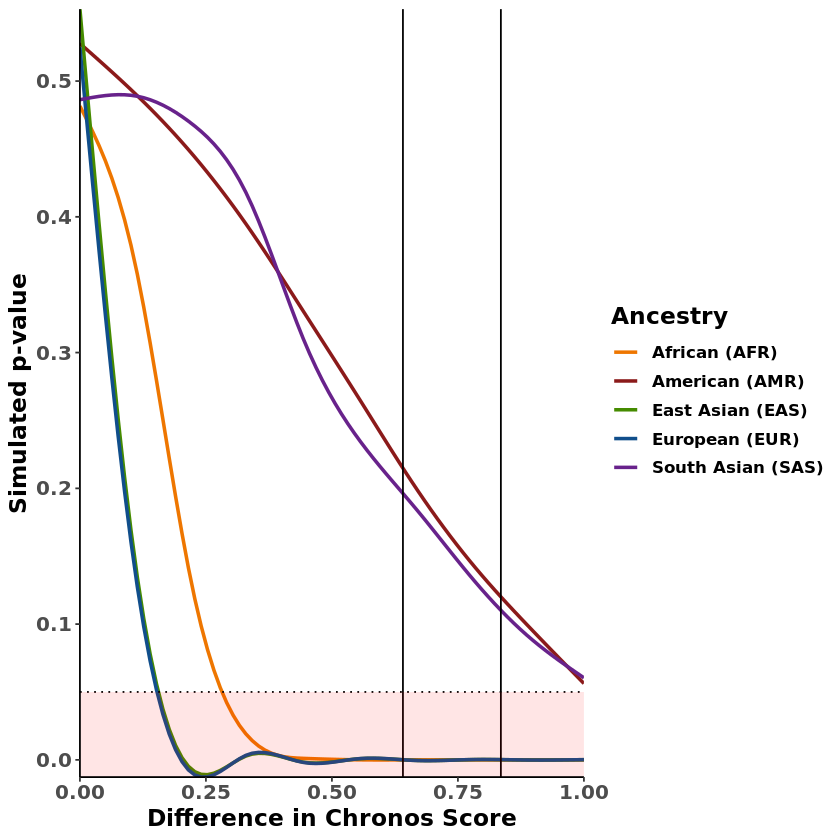

In [12]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")


#Merge the dataset together
cbind(median.differences, final.afr.pval.vector, final.amr.pval.vector, final.eas.pval.vector, final.eur.pval.vector, final.sas.pval.vector) %>%
data.frame() %>%
rename("median.difference" = 1, "African (AFR)" = 2, "American (AMR)" = 3, "East Asian (EAS)" = 4, "European (EUR)" = 5, "South Asian (SAS)" = 6) %>%
melt(id = "median.difference") %>%
rename("Ancestry" = variable) %>%
mutate(valiue = -log10(value)) %>%

#Draw the plot 
ggplot(aes(x = median.difference, y = value, color = Ancestry)) +
geom_smooth(se = FALSE, method = "gam") +
geom_hline(yintercept = 0.05, lty = 3) +
geom_vline(xintercept = c(braf.differential, kras.differential)) +

annotate("rect", xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = 0.05, fill = "red", alpha = .1, color = NA) +

theme_bw() +
scale_colour_manual(values = group.colors) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
  ) +

ylab("Simulated p-value") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0))


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("powercalc.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp powercalc.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


# Now calculate statistical power with the pwr package

In [13]:
#Load in a list of common essentials and create a vector
setwd('/home/jupyter/Ancestry/gwas')
common.essentials = read.table("internal-22q1_v24-crispr-common-essentials.csv", sep = ",") %>%
mutate(genes = word(V1)) %>%
slice(-1) %>%
pull(genes) 

#Load in the chronos data
setwd('/home/jupyter/Ancestry/gwas')
ccle.chronos = read.table('CRISPR_gene_effect.csv', sep = ",", header = T, check.names = FALSE) %>%
rename( "sample" = 1) %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.14789625,0.05463471,0.001419604,-0.01339043,-0.10349883,-0.01125857,0.006416150,-0.3134714,0.006768761,⋯,-0.07102683,-0.09653835,-0.02783783,0.109681058,0.15538259,-0.11208185,0.08538044,0.155184455,0.063520777,-0.33008466
2,ACH-000004,0.04225404,-0.03722391,-0.110746309,-0.01216771,0.04928672,-0.13341834,0.146940684,-0.2059332,0.110355464,⋯,-0.03456611,-0.24942696,0.10866321,0.038576149,0.05678273,0.06712849,-0.16562203,0.127003760,0.112792741,-0.02744917
3,ACH-000005,-0.09725072,0.03138132,0.056310037,0.14384058,-0.01691672,-0.16512957,0.129443530,-0.2582329,-0.078755273,⋯,-0.07883775,-0.24704082,-0.04526586,-0.004562731,-0.02503393,-0.12468651,-0.11999691,0.047232733,-0.008179104,-0.09600739
4,ACH-000007,-0.02114864,-0.08354835,0.064540722,0.07293326,-0.02168035,-0.03812946,-0.019298595,-0.2071468,-0.065116712,⋯,-0.25412460,-0.46013587,0.05273457,0.162883734,0.10396785,-0.02976377,-0.17820933,-0.126332483,-0.185517858,-0.28405535
5,ACH-000009,-0.02221356,-0.03932445,0.068163523,0.07960398,0.02605992,-0.07865008,-0.008861441,-0.1818317,0.010320843,⋯,-0.19291138,-0.33573379,0.01216716,0.189156924,-0.04495579,-0.13131152,-0.33177966,-0.002488554,-0.068758583,-0.22810072
6,ACH-000011,0.07938469,-0.05681123,0.046281449,0.21295376,-0.09828782,-0.23423752,-0.067585065,-0.1514126,0.047989598,⋯,-0.51411266,-0.48357923,0.05012691,0.116754733,0.21111247,0.08775948,-0.12456308,-0.119781600,-0.120450263,-0.21757298


In [14]:
#Get the intersecting genes between the ccle.chronos genes and the common.essential genes
genes.to.keep = intersect(common.essentials, names(ccle.chronos))

#Calculate the sd for all common essentials
common.essential.sd = ccle.chronos %>%
select(all_of(genes.to.keep)) %>%
apply(2, sd) %>%
median(na.rm = TRUE)

common.essential.sd

[1] 0.2477601

In [15]:
#Create a vector of d values for the power calculation
#d is defined as 'difference in means' divided by common standard deviation
top.value = seq(from = 0, to = 1, by = 0.01)
bottom.value = 0
d.vector = ((top.value - bottom.value)/common.essential.sd)

In [16]:
#Now perform the power calculations for each ancestry group
afr.power = pwr.t2n.test(n1 = length.AFR, n2 = length.non.AFR, d = d.vector, sig.level = 0.05, power = NULL)$power
amr.power = pwr.t2n.test(n1 = length.AMR, n2 = length.non.AMR, d = d.vector, sig.level = 0.05, power = NULL)$power
eas.power = pwr.t2n.test(n1 = length.EAS, n2 = length.non.EAS, d = d.vector, sig.level = 0.05, power = NULL)$power
eur.power = pwr.t2n.test(n1 = length.EUR, n2 = length.non.EUR, d = d.vector, sig.level = 0.05, power = NULL)$power
sas.power = pwr.t2n.test(n1 = length.SAS, n2 = length.non.SAS, d = d.vector, sig.level = 0.05, power = NULL)$power

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



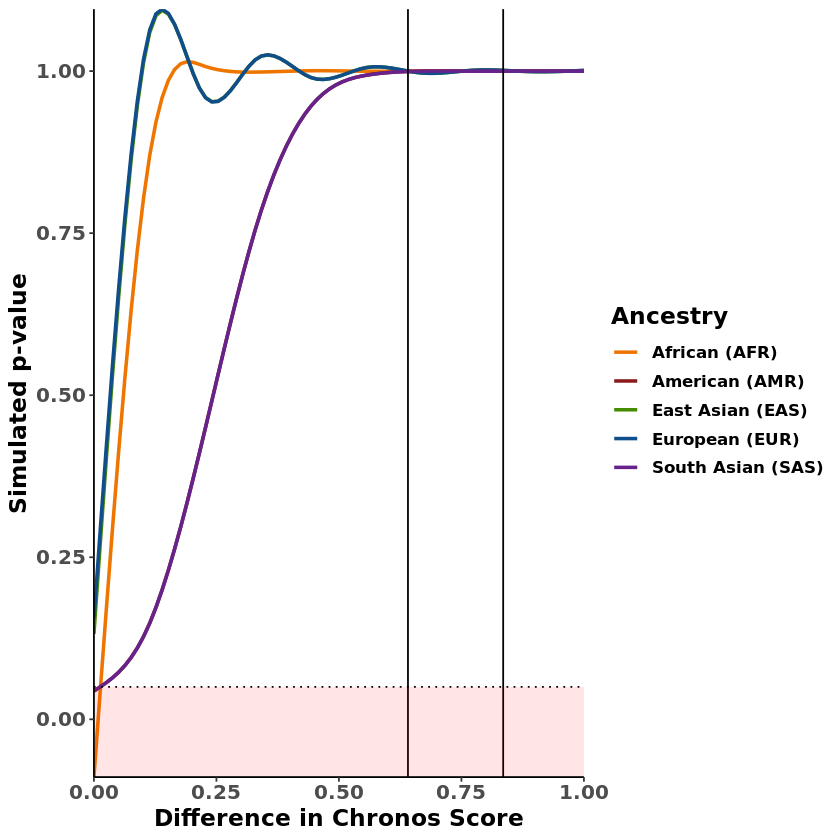

In [17]:
#Now plot this new power calculation
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")


#Merge the dataset together
cbind(top.value, afr.power, amr.power, eas.power, eur.power, sas.power) %>%
data.frame() %>%
rename("median.difference" = 1, "African (AFR)" = 2, "American (AMR)" = 3, "East Asian (EAS)" = 4, "European (EUR)" = 5, "South Asian (SAS)" = 6) %>%
melt(id = "median.difference") %>%
rename("Ancestry" = variable) %>%
mutate(valiue = -log10(value)) %>%

#Draw the plot 
ggplot(aes(x = median.difference, y = value, color = Ancestry)) +
geom_smooth(se = FALSE, method = "gam") +
geom_hline(yintercept = 0.05, lty = 3) +
geom_vline(xintercept = c(braf.differential, kras.differential)) +

annotate("rect", xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = 0.05, fill = "red", alpha = .1, color = NA) +

theme_bw() +
scale_colour_manual(values = group.colors) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
  ) +

ylab("Simulated p-value") +
xlab("Difference in Chronos Score") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0))

In [18]:
#Create a vector of d differences that correspond to median differences of 0 - 1 with intervals of 0.1
small.d.vector = seq(from = 0, to = 1, by = 0.1)/common.essential.sd
n.vector = seq(from = 2, to = 1000, by = 1)

power.values = NULL
for(num in n.vector){
    temp.power = pwr.t2n.test(n1 = num, n2 = num, d = small.d.vector, sig.level = 0.05, power = NULL)$power
    power.values = rbind(power.values, temp.power)
}

In [19]:
#Format the dataset
power.values.for.plotting = power.values %>%
data.frame() %>%
mutate(n.samples = n.vector) %>%
rename("0.0"=1, "0.1"=2, "0.2"=3, "0.3"=4, "0.4"=5, "0.5"=6, "0.6"=7, "0.7"=8, "0.8"=9, "0.9"=10, "1.0"=11, "SampleNum"=12) %>%
melt(id = "SampleNum")

head(power.values.for.plotting)

,SampleNum,variable,value
,<dbl>,<fct>,<dbl>
1,2,0.0,0.05
2,3,0.0,0.05
3,4,0.0,0.05
4,5,0.0,0.05
5,6,0.0,0.05
6,7,0.0,0.05


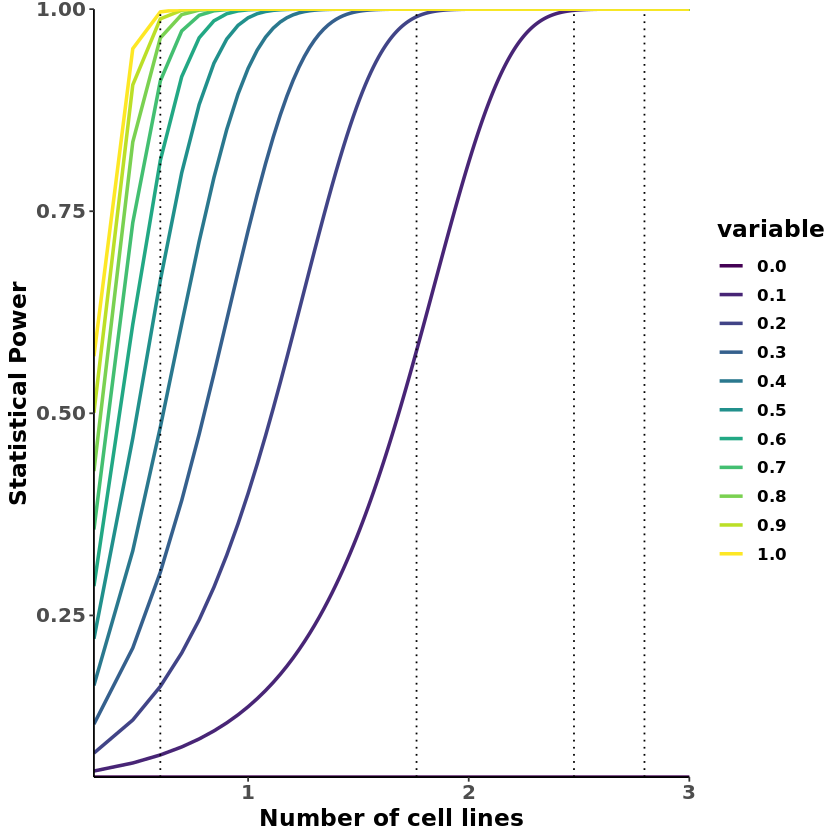

In [33]:
#Now plot the plot!

power.values.for.plotting %>%
ggplot() +
geom_line(aes(x = log10(SampleNum), y = value, color = variable), size = 1) +
geom_vline(xintercept = c(log10(length.AFR), log10(length.AMR), log10(length.EAS), log10(length.EUR), log10(length.SAS)), linetype="dotted") +
theme_bw() +

scale_color_viridis(discrete = TRUE) +

theme(
panel.border = element_blank(), 
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black"),
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold"),
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold"),
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("Statistical Power") +
xlab("Number of cell lines") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("powercalc_numlines.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp powercalc_numlines.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

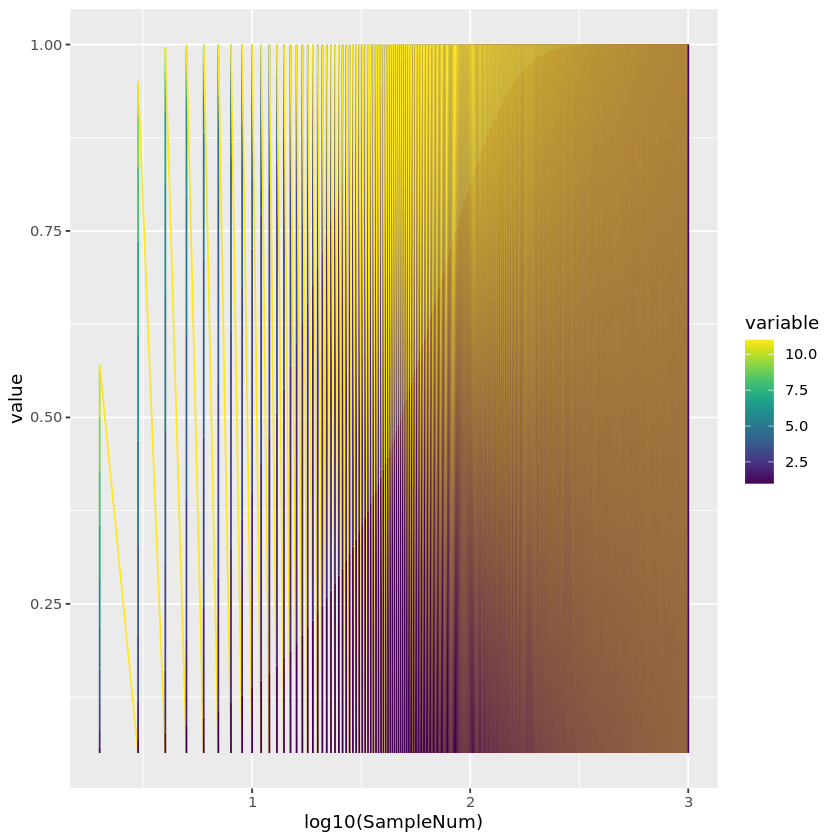

In [27]:
#Now make a plot so that we can grab the legend colorbar
power.values.for.plotting %>%
mutate(variable = as.numeric(variable)) %>%
ggplot() +
geom_line(aes(x = log10(SampleNum), y = value, color = variable)) +
scale_color_viridis(discrete = FALSE)

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("powercalc_numlines_scalebar.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp powercalc_numlines_scalebar.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))